# Pre-Processing and Training Data<a id='Pre-Processing_and_Training_Data'></a>

In [425]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
from sklearn import __version__ as sklearn_version
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime

from library.sb_utils import save_file

In [2]:
patient_data = pd.read_csv('../data/patient_data_cleaned.csv')
patient_data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289.0,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180.0,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283.0,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214.0,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195.0,0,Normal,122,N,0.0,Up,0


In [3]:
#Extract Heart Disease column
HD = patient_data['HeartDisease']

In [4]:
patient_data = patient_data.loc[:, patient_data.columns != 'HeartDisease']
patient_data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
0,40,M,ATA,140,289.0,0,Normal,172,N,0.0,Up
1,49,F,NAP,160,180.0,0,Normal,156,N,1.0,Flat
2,37,M,ATA,130,283.0,0,ST,98,N,0.0,Up
3,48,F,ASY,138,214.0,0,Normal,108,Y,1.5,Flat
4,54,M,NAP,150,195.0,0,Normal,122,N,0.0,Up


In [5]:
#Test Train Split
X_train, X_test, y_train, y_test = train_test_split(patient_data, HD, test_size=0.25, random_state=42)

In [6]:
X_train.shape, X_test.shape

((687, 11), (230, 11))

In [7]:
y_train.shape, y_test.shape

((687,), (230,))

In [9]:
X_train.dtypes

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol       float64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
dtype: object

In [10]:
X_test.dtypes

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol       float64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
dtype: object

In [339]:
#One-hot encoding object features
X_train = pd.get_dummies(X_train, drop_first = True)
X_train.shape

(687, 15)

In [12]:
X_test = pd.get_dummies(X_test, drop_first = True)
X_test.shape

(230, 15)

In [13]:
X_train.dtypes

Age                    int64
RestingBP              int64
Cholesterol          float64
FastingBS              int64
MaxHR                  int64
Oldpeak              float64
Sex_M                  uint8
ChestPainType_ATA      uint8
ChestPainType_NAP      uint8
ChestPainType_TA       uint8
RestingECG_Normal      uint8
RestingECG_ST          uint8
ExerciseAngina_Y       uint8
ST_Slope_Flat          uint8
ST_Slope_Up            uint8
dtype: object

In [14]:
X_test.dtypes

Age                    int64
RestingBP              int64
Cholesterol          float64
FastingBS              int64
MaxHR                  int64
Oldpeak              float64
Sex_M                  uint8
ChestPainType_ATA      uint8
ChestPainType_NAP      uint8
ChestPainType_TA       uint8
RestingECG_Normal      uint8
RestingECG_ST          uint8
ExerciseAngina_Y       uint8
ST_Slope_Flat          uint8
ST_Slope_Up            uint8
dtype: object

## Initial Baseline-Model<a id='Initial_Baseline-Model'></a>

In [430]:
#Creation of Baseline-Model based on uniform random predictions (coin flips)
dumb_clf = DummyClassifier(strategy='uniform')
dumb_clf.fit(X_train, y_train)

DummyClassifier(strategy='uniform')

In [427]:
y_tr_pred = dumb_clf.predict(X_train)
y_tr_pred[:5]

array([0, 1, 0, 1, 1])

In [428]:
y_te_pred = dumb_clf.predict(X_test)
y_te_pred[:5]

array([0, 1, 0, 1, 1])

In [429]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(0.5225618631732168, 0.41739130434782606)

## Linear Regression Model<a id='Linear_Regression_Model'></a>

In [442]:
pipe = make_pipeline(
    SimpleImputer(strategy='median'), 
    StandardScaler(), 
    SelectKBest(score_func = f_regression),
    LinearRegression()
)

In [443]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(score_func=<function f_regression at 0x7f92ba164940>)),
                ('linearregression', LinearRegression())])

In [444]:
y_tr_pred = pipe.predict(X_train)
y_te_pred = pipe.predict(X_test)

In [445]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(0.24100504181980173, 0.24626092767538157)

## Random Search and Cross-validation<a id='Random_Search_and_Cross-validation'></a>

In [446]:
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'simpleimputer', 'standardscaler', 'selectkbest', 'linearregression', 'simpleimputer__add_indicator', 'simpleimputer__copy', 'simpleimputer__fill_value', 'simpleimputer__missing_values', 'simpleimputer__strategy', 'simpleimputer__verbose', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'selectkbest__k', 'selectkbest__score_func', 'linearregression__copy_X', 'linearregression__fit_intercept', 'linearregression__n_jobs', 'linearregression__normalize', 'linearregression__positive'])

In [447]:
k = [k+1 for k in range(len(X_train.columns))]
params = {'selectkbest__k': k}

In [448]:
lr_random_cv = RandomizedSearchCV(pipe, params, n_iter=5, cv=5, n_jobs=-1)

In [449]:
lr_random_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('simpleimputer',
                                              SimpleImputer(strategy='median')),
                                             ('standardscaler',
                                              StandardScaler()),
                                             ('selectkbest',
                                              SelectKBest(score_func=<function f_regression at 0x7f92ba164940>)),
                                             ('linearregression',
                                              LinearRegression())]),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7,
                                                           8, 9, 10, 11, 12, 13,
                                                           14, 15]})

In [452]:
lr_best_cv_results = cross_validate(lr_random_cv.best_estimator_, X_train, y_train, cv=5)
lr_best_scores = lr_best_cv_results['test_score']
lr_best_scores

array([0.61123518, 0.57473857, 0.58253608, 0.49657634, 0.46402858])

In [453]:
np.mean(lg_best_scores), np.std(lg_best_scores)

(0.851443986036179, 0.033751033846965504)

In [342]:
lr_random_cv.best_params_

{'selectkbest__k': 15}

In [29]:
selected = lr_random_cv.best_estimator_.named_steps.selectkbest.get_support()

In [340]:
#Feature importance for linear regression
coefs = lr_random_cv.best_estimator_.named_steps.linearregression.coef_
features = X_train.columns[selected]
pd.Series(data = coefs, index=features).sort_values(ascending=False)

ExerciseAngina_Y     0.069090
Sex_M                0.063476
ST_Slope_Flat        0.058114
FastingBS            0.056953
Oldpeak              0.053994
Age                  0.012749
RestingECG_ST        0.004107
RestingECG_Normal    0.000149
RestingBP           -0.002242
Cholesterol         -0.019185
MaxHR               -0.023106
ChestPainType_TA    -0.044212
ChestPainType_NAP   -0.093135
ChestPainType_ATA   -0.093275
ST_Slope_Up         -0.135425
dtype: float64

## Random Forest Model<a id='Random_Forest_Model'></a>

In [31]:
RF_pipe = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler(),
    RandomForestRegressor(random_state=42)
)

In [32]:
rf_default_cv_results = cross_validate(RF_pipe, X_train, y_train, cv=5)

In [33]:
rf_cv_scores = rf_default_cv_results['test_score']
rf_cv_scores

array([0.58435383, 0.51716553, 0.47168675, 0.46641336, 0.43908959])

In [34]:
np.mean(rf_cv_scores), np.std(rf_cv_scores)

(0.49574181259617384, 0.050910398769674015)

In [284]:
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
params = {
        'randomforestregressor__n_estimators': n_est,
        'standardscaler': [StandardScaler(), MinMaxScaler(), None],
        'simpleimputer__strategy': ['mean', 'median']
}
params

{'randomforestregressor__n_estimators': [10,
  12,
  16,
  20,
  26,
  33,
  42,
  54,
  69,
  88,
  112,
  143,
  183,
  233,
  297,
  379,
  483,
  615,
  784,
  1000],
 'standardscaler': [StandardScaler(), MinMaxScaler(), None],
 'simpleimputer__strategy': ['mean', 'median']}

In [285]:
rf_random_cv = RandomizedSearchCV(RF_pipe, params, cv=5, n_jobs=-1)

In [286]:
rf_random_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('simpleimputer',
                                              SimpleImputer(strategy='median')),
                                             ('standardscaler',
                                              StandardScaler()),
                                             ('randomforestregressor',
                                              RandomForestRegressor(random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'randomforestregressor__n_estimators': [10,
                                                                                12,
                                                                                16,
                                                                                20,
                                                                                26,
                                                                                33,
        

In [287]:
rf_random_cv.best_params_

{'standardscaler': MinMaxScaler(),
 'simpleimputer__strategy': 'mean',
 'randomforestregressor__n_estimators': 784}

In [288]:
rf_best_cv_results = cross_validate(rf_random_cv.best_estimator_, X_train, y_train, cv=5)
rf_best_scores = rf_best_cv_results['test_score']
rf_best_scores

array([0.59558028, 0.51827219, 0.4718485 , 0.47646018, 0.43700387])

In [289]:
np.mean(rf_best_scores), np.std(rf_best_scores)

(0.4998330051357248, 0.05437732232822921)

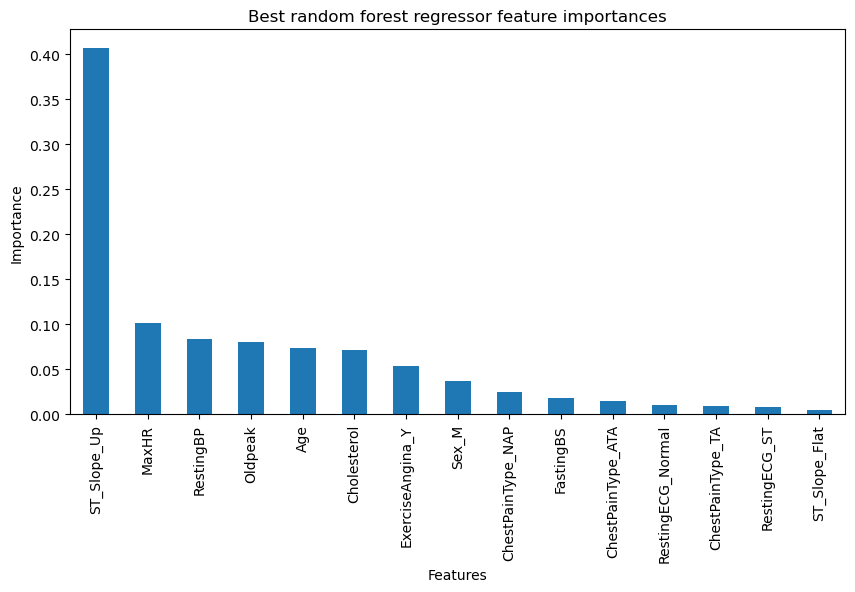

In [290]:
plt.subplots(figsize=(10, 5))
imps = rf_random_cv.best_estimator_.named_steps.randomforestregressor.feature_importances_
rf_feat_imps = pd.Series(data = imps, index=X_train.columns).sort_values(ascending=False)
rf_feat_imps.plot(kind='bar')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Best random forest regressor feature importances');

## Logistic Regression Model<a id='Logistic_Regression_Model'></a>

In [395]:
lg_pipe = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler(),
    LogisticRegression(random_state=42)
)

In [396]:
lg_default_cv_results = cross_validate(LG_pipe, X_train, y_train, cv=5)

In [397]:
lg_cv_scores = LG_default_cv_results['test_score']
lg_cv_scores

array([0.89130435, 0.85507246, 0.86131387, 0.82481752, 0.81021898])

In [398]:
np.mean(lg_cv_scores), np.std(lg_cv_scores)

(0.8485454353115411, 0.028516279418125623)

In [399]:
lg_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'simpleimputer', 'standardscaler', 'logisticregression', 'simpleimputer__add_indicator', 'simpleimputer__copy', 'simpleimputer__fill_value', 'simpleimputer__missing_values', 'simpleimputer__strategy', 'simpleimputer__verbose', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'logisticregression__C', 'logisticregression__class_weight', 'logisticregression__dual', 'logisticregression__fit_intercept', 'logisticregression__intercept_scaling', 'logisticregression__l1_ratio', 'logisticregression__max_iter', 'logisticregression__multi_class', 'logisticregression__n_jobs', 'logisticregression__penalty', 'logisticregression__random_state', 'logisticregression__solver', 'logisticregression__tol', 'logisticregression__verbose', 'logisticregression__warm_start'])

In [400]:
param_grid = [
    {
    'penalty' : ['l1', 'l2'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['liblinear']}]

lg_random_cv = RandomizedSearchCV(LogisticRegression(random_state=42), param_grid, cv = 5, n_jobs=-1)


In [401]:
lg_random_cv.fit(X_train,y_train)


RandomizedSearchCV(cv=5, estimator=LogisticRegression(random_state=42),
                   n_jobs=-1,
                   param_distributions=[{'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                                         'penalty': ['l1', 'l2'],
                                         'solver': ['liblinear']}])

In [402]:
lg_random_cv.best_params_

{'solver': 'liblinear', 'penalty': 'l1', 'C': 0.615848211066026}

In [440]:
lg_best_cv_results = cross_validate(lg_random_cv.best_estimator_, X_train, y_train, cv=5)
lg_best_scores = lg_best_cv_results['test_score']
lg_best_scores

array([0.89855072, 0.86231884, 0.86861314, 0.82481752, 0.80291971])

In [404]:
np.mean(lg_best_scores), np.std(lg_best_scores)

(0.8514545646884587, 0.032419549790561136)

In [454]:
best_model = lg_random_cv.best_estimator_

In [455]:
#Feature importance for logistic regression
coef = best_model.coef_[0]
features = X_train.columns
pd.Series(data = coefs, index=features).sort_values(ascending=False)

ExerciseAngina_Y     0.069090
Sex_M                0.063476
ST_Slope_Flat        0.058114
FastingBS            0.056953
Oldpeak              0.053994
Age                  0.012749
RestingECG_ST        0.004107
RestingECG_Normal    0.000149
RestingBP           -0.002242
Cholesterol         -0.019185
MaxHR               -0.023106
ChestPainType_TA    -0.044212
ChestPainType_NAP   -0.093135
ChestPainType_ATA   -0.093275
ST_Slope_Up         -0.135425
dtype: float64

## Final Model Selection<a id='Final_Model_Selection'></a>

### Linear regression model performance<a id='_Linear_regression_model_performance'></a>

In [456]:
lr_neg_mae = cross_validate(lr_random_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [457]:
lr_mae_mean = np.mean(-1 * lr_neg_mae['test_score'])
lr_mae_std = np.std(-1 * lr_neg_mae['test_score'])
lr_mae_mean, lr_mae_std

(0.24424951279380158, 0.015351919488809944)

In [458]:
mean_absolute_error(y_test, lr_random_cv.best_estimator_.predict(X_test))

0.24626092767538157

### Random forest regression model performance<a id='Random_forest_regression_model_performance'></a>

In [410]:
rf_neg_mae = cross_validate(rf_random_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [411]:
rf_mae_mean = np.mean(-1 * rf_neg_mae['test_score'])
rf_mae_std = np.std(-1 * rf_neg_mae['test_score'])
rf_mae_mean, rf_mae_std

(0.23600770838325813, 0.015869286984341112)

In [412]:
mean_absolute_error(y_test, rf_random_cv.best_estimator_.predict(X_test))

0.23444432120674355

### Logistic regression model performance<a id='Logistic_regression_model_performance'></a>

In [413]:
lg_neg_mae = cross_validate(lg_random_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [414]:
lg_mae_mean = np.mean(-1 * lg_neg_mae['test_score'])
lg_mae_std = np.std(-1 * lg_neg_mae['test_score'])
lg_mae_mean, lg_mae_std

(0.148556013963821, 0.033751033846965504)

In [415]:
mean_absolute_error(y_test, lg_random_cv.best_estimator_.predict(X_test))

0.11304347826086956

## Data quantity assessment<a id='Data_quantity_assessment'></a>

In [416]:
fractions = [.2, .25, .3, .35, .4, .45, .5, .6, .75, .8, 1.0]
train_size, train_scores, test_scores = learning_curve(lg_pipe, X_train, y_train, train_sizes=fractions)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

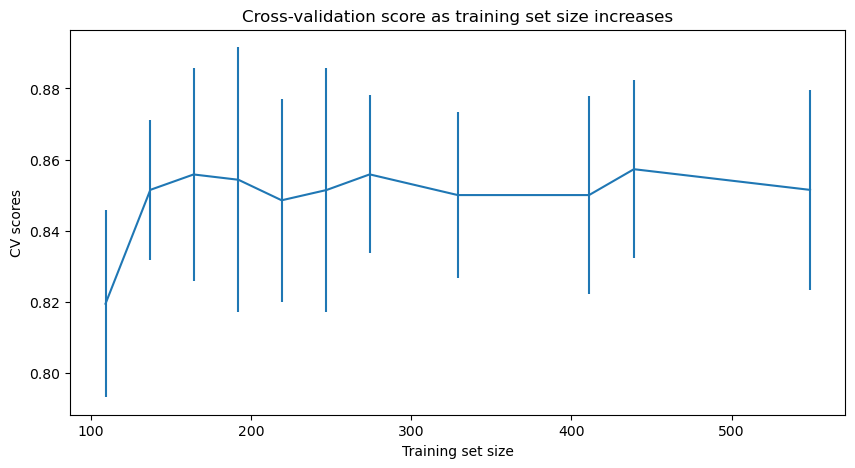

In [336]:
plt.subplots(figsize=(10, 5))
plt.errorbar(train_size, test_scores_mean, yerr=test_scores_std)
plt.xlabel('Training set size')
plt.ylabel('CV scores')
plt.title('Cross-validation score as training set size increases');

## Best Model from Pipeline<a id='Best_Model_from_Pipeline'></a>

In [337]:
best_model = lg_random_cv.best_estimator_
best_model.version = 1.0
best_model.pandas_version = pd.__version__
best_model.numpy_version = np.__version__
best_model.sklearn_version = sklearn_version
best_model.X_columns = [col for col in X_train.columns]
best_model.build_datetime = datetime.datetime.now()

In [338]:
# saveing model

modelpath = '../models'
save_file(best_model, 'heart_disease_model.pkl', modelpath)

Directory ../models was created.
Writing file.  "../models/heart_disease_model.pkl"


## Summary<a id='Summary'></a>

To preprocess the provided data and determine the appropriate model for further analysis, I initiated the following steps. Firstly, I partitioned the data into a 75/25 train-test split. To establish a baseline, I conducted a test scenario where random predictions were generated uniformly, allowing me to assess the baseline model. Subsequently, I created three pipelines for modeling: linear regression, random forest, and logistic regression. These pipelines were fitted with the data, employing median imputation for missing values. With the pipelines ready, I efficiently trained, fine-tuned, and cross-validated each model, evaluating the outcomes.

Comparing the results to the baseline model, which exhibited a mean absolute error of 0.42 in its test predictions, the linear regression model, with optimal hyperparameters, achieved a mean absolute error of 0.25. The random forest model followed with a mean absolute error of 0.23, while the logistic model yielded the lowest error of 0.11. Consequently, the logistic model proved to be the most accurate and suitable for our future predictions.

Finally, I examined the cross-validation performance of the logistic model concerning the training size. Notably, the cross-validation demonstrated minimal variance after a training size of approximately 150. Based on this analysis, I determined that additional samples would not be necessary for further modeling.
